In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math

# Correlation Analysis:


In [2]:
Indices = yf.download(tickers=["^IXIC", "^NSEI"], start="2010-01-01", end = "2023-05-01")

[*********************100%***********************]  2 of 2 completed


In [3]:
# extra
Indices.columns

MultiIndex([('Adj Close', '^IXIC'),
            ('Adj Close', '^NSEI'),
            (    'Close', '^IXIC'),
            (    'Close', '^NSEI'),
            (     'High', '^IXIC'),
            (     'High', '^NSEI'),
            (      'Low', '^IXIC'),
            (      'Low', '^NSEI'),
            (     'Open', '^IXIC'),
            (     'Open', '^NSEI'),
            (   'Volume', '^IXIC'),
            (   'Volume', '^NSEI')],
           )

In [4]:
Indices.dropna(inplace=True)

In [5]:
nasdaq_prices = Indices.loc[:, 'Adj Close']['^IXIC']
nifty_prices = Indices.loc[:, 'Adj Close']['^NSEI']

In [6]:
prices_df = pd.concat([nasdaq_prices, nifty_prices], axis=1, keys=['NASDAQ', 'NIFTY'])


In [7]:
prices_df

,NASDAQ,NIFTY
Date,,
2010-01-04,2308.419922,5232.200195
2010-01-05,2308.709961,5277.899902
2010-01-06,2301.090088,5281.799805
2010-01-07,2300.050049,5263.100098
2010-01-08,2317.169922,5244.750000
...,...,...
2023-04-24,12037.200195,17743.400391
2023-04-25,11799.160156,17769.250000
2023-04-26,11854.349609,17813.599609


In [8]:
correlation = prices_df['NASDAQ'].corr(prices_df['NIFTY'])
print("Correlation Coeff.: ", correlation)

Correlation Coeff.:  0.9513138758576779


The correlation coefficient of 0.9513 suggests a **strong** (as absolute value is close to 1) and **positive** (as the coeff. is positive) correlation between the two indices


# Lead-Lag Relationship


-148 0.9677174313611793


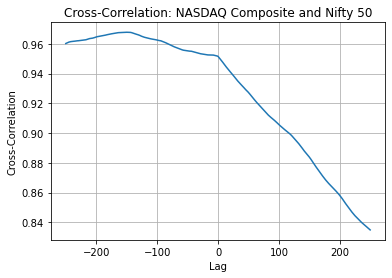

In [9]:
# Calculate cross-correlation
cross_corr = np.correlate(nasdaq_prices, nifty_prices, mode='full')

# Create lag array for x-axis
# lags = np.arange(-(len(nasdaq_prices)-1), len(nasdaq_prices))
lags = np.arange(-250, 250, 1)

cross_corr = []
for lag in lags :
    shifted_nifty = prices_df['NIFTY'].shift(lag)
    correlation = prices_df['NASDAQ'].corr(shifted_nifty)
    cross_corr.append(correlation)

best_lag = lags[cross_corr.index(max(cross_corr))]
print(best_lag, max(cross_corr))
# Plot cross-correlation
plt.plot(lags, cross_corr)
plt.title('Cross-Correlation: NASDAQ Composite and Nifty 50')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.grid(True)
plt.show()


Inferences from above chart:

- The stronges correlation between the two indices appears at -148 days
- The NASDAQ Composite index consistently lags behind Nifty 50 by 148 days
- Thus, NIFTY 50 shall be used for parameter optimization because of its consistent leading behaviour


# INDICATOR CODING



In [10]:
# Nifty Values
High = Indices["High"].loc[:, ('^NSEI')]
Low = Indices["Low"].loc[:, ('^NSEI')]
Close = Indices["Adj Close"].loc[:, ('^NSEI')]


KELTNER CHANNEL

In [11]:
# Average True Range (ATR)
def ATR(atr_lookback, high, low, close ):
    
    tr1 = pd.DataFrame(abs(High - Low))
    tr2 = pd.DataFrame(abs(High - Close.shift()))
    tr3 = pd.DataFrame(abs(Low - Close.shift()))
    true_range = pd.concat([tr1, tr2, tr3], axis = 1, join='inner').max(axis=1)
    # true_range_nifty = high_low_nifty.rolling(atr_period).mean()
    atr = true_range.ewm(span = atr_lookback, adjust = False).mean()
    return atr

def Keltner_Channel(high, low, close, kc_lookback=20, atr_period=10, multiplier=2):
    atr = ATR(atr_period, high, low, close)
    Ema = close.ewm(span = kc_lookback, adjust=False).mean()
    upper_band = Ema + (multiplier * atr)
    lower_band = Ema - (multiplier * atr)
    middle_band = Ema
    return upper_band, middle_band, lower_band

BOLLINGER BANDS


In [12]:
def Bollinger_Bands(high, low, close, n=20, num_std = 2):
    moving_average = close.rolling(window=n).mean()
    moving_std = close.rolling(window = n).std()
    upper_band = moving_average + num_std* moving_std 
    lower_band = moving_average - num_std* moving_std 
    return upper_band,lower_band

MACD INDICATOR

In [13]:
def MACD_indicator(high, low, close,lower_window = 12,upper_window = 26,signal_window = 9):
    ema_12 = close.ewm(span = lower_window,adjust = False).mean()
    ema_26 = close.ewm(span = upper_window,adjust = False).mean()
    macd = ema_12 - ema_26
    signal_line = macd.ewm(span = signal_window,adjust = False).mean()
    return macd,signal_line

# STRATEGY


KELTNER CHANNEL


In [14]:
def Keltner_Channel_Strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)-1):
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal

def fill_position(signal, Close):
    position = Close.copy()
    for i in range(len(Close)):
        position[i] = 0

    for i in range(1,len(Close)-1, 1):
        if signal[i] == 1:
            position[i] = 1
        elif signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]

    return position


BOLLINGER BANDS

In [15]:
def Bollinger_Bands_Strategy(close, lower_band, upper_band):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(close)):
        if i>0 and close[i-1] > lower_band[i-1] and close[i] < lower_band[i]:
            if signal != 1:
                buy_price.append(close[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif i>0 and close[i-1] < upper_band[i-1] and close[i] > upper_band[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal



MACD INDICATOR

In [16]:
def MACD_Strategy(close, macd, signal_line):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(macd)):
        if macd[i] > signal_line[i]:
            if signal != 1:
                buy_price.append(close[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif macd[i] < signal_line[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

# PARAMETER OPTIMIZATION

KELTNER CHANNEL


In [17]:
parameter_ranges_kc = {
    'kc_lookback': range(16, 24, 1),
    'atr_period' : range(8,12, 1),
    'multiplier' : np.arange(1.9, 2.1, 0.01),
}
best_parameteres_kc = {}


** may take upto 2 minutes each for parameter optimization **

In [19]:
best_returns = float('-inf')


for kc_lookback in parameter_ranges_kc['kc_lookback']:
    for atr_period in parameter_ranges_kc['atr_period']:
        for multiplier in parameter_ranges_kc['multiplier']:
            upper_kc,middle_kc,lower_kc = Keltner_Channel(High, Low, Close,kc_lookback, atr_period, multiplier)

            buy_price, sell_price, kc_signal = Keltner_Channel_Strategy(Close, upper_kc, lower_kc)

            kc_position = fill_position(kc_signal, Close)

            Returns = pd.DataFrame(np.diff(Close)).rename(columns = {0:'returns'})

            investment_value = 0
            total_returns = 0
            flag = 0

            for i in range(len(Returns)):
                total_returns+= kc_position[i]*Returns['returns'][i]
                if kc_position[i] == 1 and flag==0:
                    investment_value = Close[i]
                    flag = 1
            metric = math.floor(total_returns*100/investment_value)
            if metric > best_returns:
                best_parameteres_kc['kc_lookback'] = kc_lookback
                best_parameteres_kc['atr_period'] = atr_period
                best_parameteres_kc['multiplier'] = multiplier
                best_returns = metric
            
print("Best parameters are:")
for i in best_parameteres_kc:
    print(i, "=" , best_parameteres_kc[i])
# print("kc_lookback = " ,best_parameteres[0])
# print("atr_period  = " ,best_parameteres[1])
# print("multiplier  = " ,best_parameteres[2])
print("Best returns = ", best_returns,"%") 

Best parameters are:
kc_lookback = 17
atr_period = 10
multiplier = 1.93
Best returns =  318 %


BOLLINGER BANDS

In [20]:
parameter_ranges_bb = {
    'ma_window' : range(15, 25, 1),
    'num_std'   : np.arange(1.5, 2.5, 0.1),
}
best_parameteres_bb = {}


In [21]:
best_returns = float('-inf')


for ma_window in parameter_ranges_bb['ma_window']:
    for num_std in parameter_ranges_bb['num_std']:
        upper_band_bb, lower_band_bb = Bollinger_Bands(High, Low, Close, ma_window, num_std)
        
        buy_price, sell_price, bb_signal = Bollinger_Bands_Strategy(Close, lower_band_bb, upper_band_bb)

        bb_position = fill_position(bb_signal, Close)

        Returns = pd.DataFrame(np.diff(Close)).rename(columns = {0:'returns'})

        investment_value = 0
        total_returns = 0
        flag = 0

        for i in range(len(Returns)):
            total_returns+= bb_position[i]*Returns['returns'][i]
            if bb_position[i] == 1 and flag==0:
                investment_value = Close[i]
                flag = 1
        metric = math.floor(total_returns*100/investment_value)
        if metric > best_returns:
            best_parameteres_bb['ma_window'] = ma_window
            best_parameteres_bb['num_std'] = num_std
            best_returns = metric
            
print("Best parameters are:")
for i in best_parameteres_bb:
    print(i, "=" , best_parameteres_bb[i])
# print("kc_lookback = " ,best_parameteres[0])
# print("atr_period  = " ,best_parameteres[1])
# print("multiplier  = " ,best_parameteres[2])
print("Best returns = ", best_returns,"%") 

Best parameters are:
ma_window = 21
num_std = 1.8000000000000003
Best returns =  191 %


MACD INDICATOR

In [24]:
parameter_ranges_macd = {
    'lower_window' : range(7, 14, 1),
    'upper_window' : range(20, 30, 1),
    'signal_window': range(7, 11, 1)
}
best_parameteres_macd = {}

In [25]:
best_returns = float('-inf')


for lower_window in parameter_ranges_macd['lower_window']:
    for upper_window in parameter_ranges_macd['upper_window']:
        for signal_window in parameter_ranges_macd['signal_window']:
            macd, signal_line = MACD_indicator(High, Low, Close,lower_window, upper_window, signal_window)
            

            buy_price, sell_price, macd_signal = MACD_Strategy(Close, macd, signal_line)

            macd_position = fill_position(macd_signal, Close)

            Returns = pd.DataFrame(np.diff(Close)).rename(columns = {0:'returns'})

            investment_value = 0
            total_returns = 0
            flag = 0

            for i in range(len(Returns)):
                total_returns+= macd_position[i]*Returns['returns'][i]
                if macd_position[i] == 1 and flag==0:
                    investment_value = Close[i]
                    flag = 1
            metric = math.floor(total_returns*100/investment_value)
            if metric > best_returns:
                best_parameteres_macd['lower_window'] = lower_window
                best_parameteres_macd['upper_window'] = upper_window
                best_parameteres_macd['signal_window'] = signal_window
                best_returns = metric
            
print("Best parameters are:")
for i in best_parameteres_macd:
    print(i, "=" , best_parameteres_macd[i])
# print("kc_lookback = " ,best_parameteres[0])
# print("atr_period  = " ,best_parameteres[1])
# print("multiplier  = " ,best_parameteres[2])
print("Best returns = ", best_returns,"%") 

Best parameters are:
lower_window = 11
upper_window = 27
signal_window = 7
Best returns =  222 %


Judging performance with optimized parameters


In [38]:
# sharpe ratio
def sharpe_ratio(data, risk_free_rate=0):
    avg_annual_returns =( pow( (data['Close'][-1]/ data['Close'][0]),365/data['Close'].size) - 1)*100
    annualised_std = data['returns'].std()
    return ((avg_annual_returns-risk_free_rate)/annualised_std)

In [39]:
upper_kc,middle_kc,lower_kc = Keltner_Channel(High, Low, nasdaq_prices,17, 10, 1.93)

buy_price, sell_price, kc_signal = Keltner_Channel_Strategy(nasdaq_prices, upper_kc, lower_kc)

kc_position = fill_position(kc_signal, Close)

Returns = pd.DataFrame(np.diff(Close)).rename(columns = {0:'returns'})

investment_value = 0
total_returns = 0
flag = 0

for i in range(len(Returns)):
    total_returns+= kc_position[i]*Returns['returns'][i]
    if kc_position[i] == 1 and flag==0:
        investment_value = Close[i]
        flag = 1




In [40]:
data_kc = pd.concat([nasdaq_prices, kc_position], axis=1)
data_kc['Close'] = data_kc['^IXIC']
data_kc['position'] = data_kc['^NSEI']
data_kc.drop('^IXIC', axis=1, inplace=True)
data_kc.drop('^NSEI', axis=1, inplace=True)
data_kc['returns'] = data_kc['Close'] - data_kc['Close'].shift()
data_kc = data_kc[data_kc['position']>0]

In [41]:
sharpe_ratio_kc = sharpe_ratio(data_kc)
sharpe_ratio_kc

0.2714656972462912

In [33]:
data_kc['Close'].size

2221

In [30]:
data_kc['Close']

Date
2010-05-07     2265.639893
2010-05-10     2374.669922
2010-05-11     2375.310059
2010-05-12     2425.020020
2010-05-13     2394.360107
                  ...     
2023-01-13    11079.160156
2023-01-17    11095.110352
2023-01-18    10957.009766
2023-01-19    10852.269531
2023-01-20    11140.429688
Name: Close, Length: 2221, dtype: float64

In [85]:
data_kc['Close'].std()

3311.1255482738297

In [86]:
data = pd.DataFrame([2, 2, 3, 4])
data.std()

0    0.957427
dtype: float64

In [78]:

data_kc

,Close,position,returns
Date,,,
2010-05-07,2265.639893,1.0,-54.000000
2010-05-10,2374.669922,1.0,109.030029
2010-05-11,2375.310059,1.0,0.640137
2010-05-12,2425.020020,1.0,49.709961
2010-05-13,2394.360107,1.0,-30.659912
...,...,...,...
2023-01-13,11079.160156,1.0,78.060547
2023-01-17,11095.110352,1.0,15.950195
2023-01-18,10957.009766,1.0,-138.100586


In [1712]:
macd, signal_line = MACD_indicator(High, Low, Close,best_parameteres_macd['lower_window'], best_parameteres_macd['upper_window'], best_parameteres_macd['signal_window'])

buy_price_macd, sell_price_macd , macd_signal = MACD_Strategy(Close, macd, signal_line)

macd_position = fill_position(macd_signal, Close)

Returns = pd.DataFrame(np.diff(Close)).rename(columns = {0:'returns'})

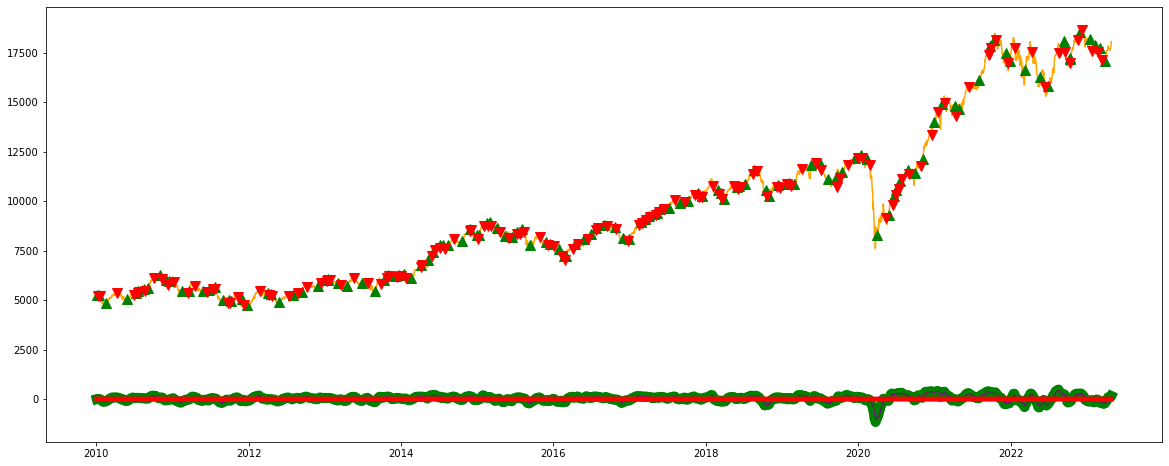

In [1720]:
plt.figure(figsize=(20, 8))
plt.plot(Close, linewidth = 1.5, color = "orange")
plt.plot(Close.tail(len(buy_price_macd)).index, buy_price_macd, marker = '^', markersize= 10, linewidth = 0, color= "green")
plt.plot(Close.tail(len(buy_price_macd)).index, sell_price_macd, marker = 'v', markersize= 10, linewidth = 0, color= "red")
plt.plot(macd.tail(len(buy_price_macd)), linewidth = 10, color = "green")
plt.plot(signal_line.tail(len(buy_price_macd)), linewidth = 1, color = "purple")
plt.plot(macd_position, linewidth=5, color = "red")

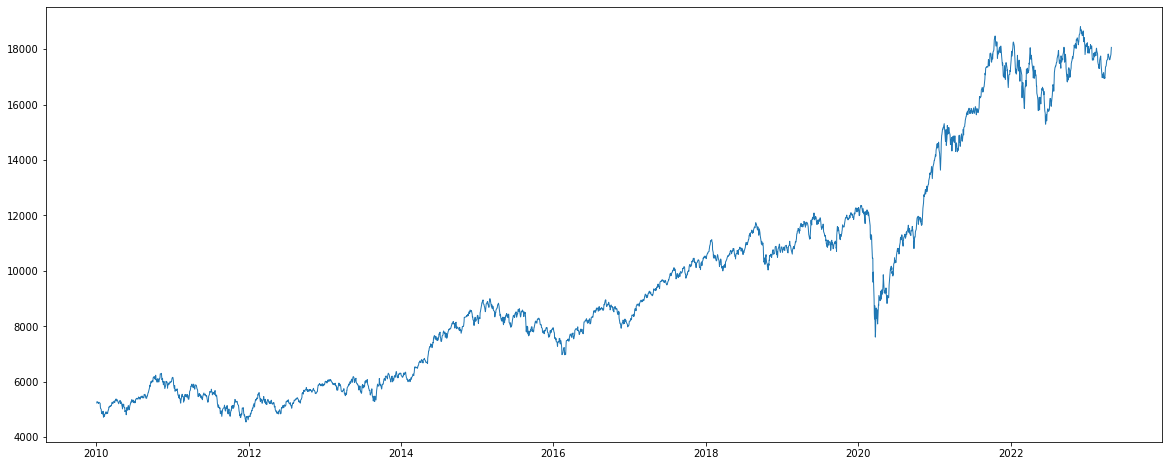

In [1684]:
plt.figure(figsize=(20, 8))
plt.plot(Close, linewidth=1, label = "Close price")
plt.

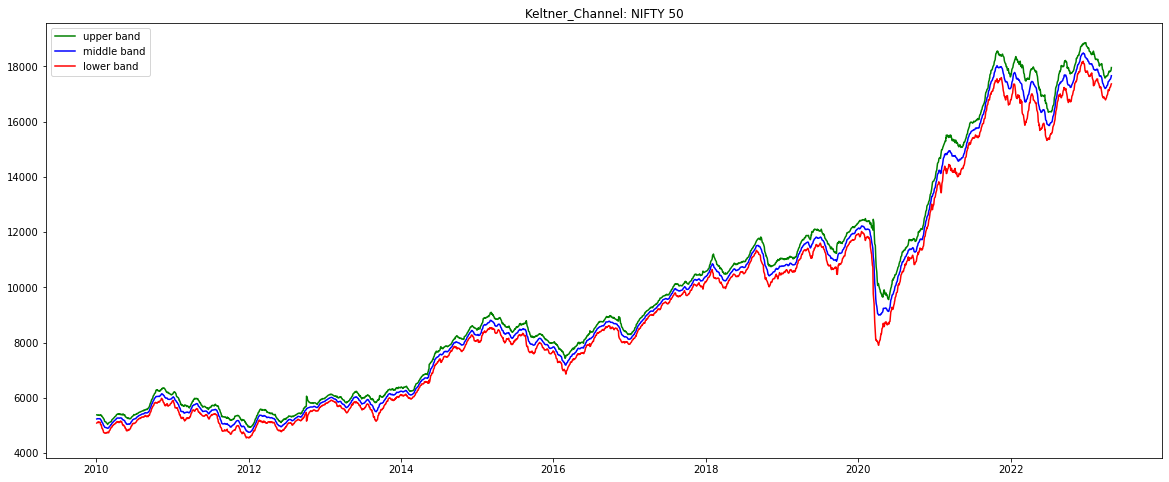

In [1563]:
##### EXTRA ####

upper_band_nifty, middle_band_nifty, lower_band_nifty = Keltner_Channel(High, Low, Close, 20, 10, 2.09)
plt.figure(figsize = (20, 8))
plt.plot(upper_band_nifty,  label = "upper band",  color = "green")
plt.plot(middle_band_nifty, label = "middle band", color = "blue")
plt.plot(lower_band_nifty,  label = "lower band",  color = "red")
# plt.plot(Close, label = "close price", color = "orange")
plt.title("Keltner_Channel: NIFTY 50")
plt.legend()
plt.show()


- Strategy


In [1685]:
best_metric = float('-inf')
best_parameteres = []


for kc_lookback in parameter_ranges['kc_lookback']:
    for atr_period in parameter_ranges['atr_period']:
        for multiplier in parameter_ranges['multiplier']:
            upper_kc,middle_kc,lower_kc = Keltner_Channel(High, Low, Close,kc_lookback, atr_period, multiplier)

            buy_price, sell_price, kc_signal = Keltner_Channel_Strategy(Close, upper_kc, lower_kc)

            kc_position = fill_position(kc_signal, Close)

            Returns = pd.DataFrame(np.diff(Close)).rename(columns = {0:'returns'})

            investment_value = 0
            total_returns = 0
            flag = 0

            for i in range(len(Returns)):
                total_returns+= kc_position[i]*Returns['returns'][i]
                if kc_position[i] == 1 and flag==0:
                    investment_value = Close[i]
                    flag = 1
            metric = math.floor(total_returns*100/investment_value)
            if metric > best_metric:
                best_parameteres = [kc_lookback, atr_period, multiplier]
                best_metric = metric
            
print("Best parameters are:")
print("kc_lookback = " ,best_parameteres[0])
print("atr_period  = " ,best_parameteres[1])
print("multiplier  = " ,best_parameteres[2])
print("Best metric = ", best_metric,"%") 
                

            

            

Best parameters are:
kc_lookback =  17
atr_period  =  10
multiplier  =  1.93
Best metric =  318 %


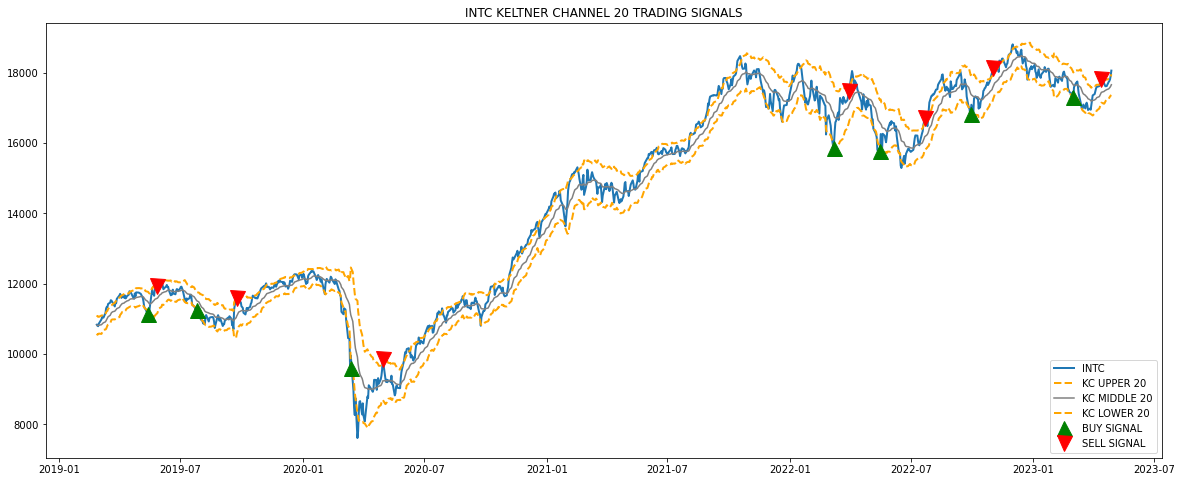

In [1567]:
# TRADING SIGNALS PLOT

plt.figure(figsize=(20,8))
plt.plot(Close.tail(1000), linewidth = 2, label = 'INTC')
plt.plot(upper_band_nifty.tail(1000), linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
plt.plot(middle_band_nifty.tail(1000), linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(lower_band_nifty.tail(1000), linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
plt.plot(Close.tail(1000).index, b_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(Indices.head(len(kc_signal)).tail(1000).index, s_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('INTC KELTNER CHANNEL 20 TRADING SIGNALS')
plt.show()